In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
def convert(value):
    '''Convert scientific notation to numbers'''
    if 'e' in value:
        v1, v2 = value.split('e')
        num = float(v1) * 10 ** (int(v2))
        return str(num)
    else:
        return value
    
class webService():
    '''Calculate the similarity between query molecule and molecules in BindingDB database,
    retrieve the most similar molecule(s) and corresponding target by the cutoff, astertain
    the possible target by the available data.
    
    Examples
    --------
    Retrieve the similar molecules and target by the query smiles and cutoff:
    >>> web = webService('c1ccccc1', '0.8')
    >>> res = web.targetBySimilarity()
    >>> res.head(3)
    ...
    
    Sort the data by a particular column:
    >>> df_sorted = web.sortCol()
    ...
    
    draw the top n mols:
    >>> web.drawMols()

    '''
    def __init__(self, smiles, cutoff):
        self.smiles = smiles
        self.cutoff = cutoff
        self.df_sorted = None
    
    def targetBySimilarity(self):
        '''Searching on the BindingDB database and parse the xml'''
        # requests
        r = requests.get('http://bindingdb.org/axis2/services/BDBService/getTargetByCompound?smiles={}&cutoff={}'.format(self.smiles, self.cutoff))
        encode = r.encoding
        print(r.status_code, encode)

        # parse xml
        soup = BeautifulSoup(r.content.decode('utf-8'), 'lxml')
        props = ['bdb:monomerid', 'bdb:inhibitor', 'bdb:target', 'bdb:uniprot', 'bdb:species', 'bdb:affinity_type',
                'bdb:affinity', 'bdb:doi', 'bdb:smiles', 'bdb:inchi', 'bdb:tanimoto']
        extrs = []
        for link in soup.find_all('bdb:affinities'):
            extr = []
            for prop in props:
                prop_value = link.find(prop).string
                extr.append(prop_value)
            extrs.append(extr)
        # convert to df
        cols = list(map(lambda x: x[4:], props))
        self.df = pd.DataFrame(extrs, columns=cols)
        return self.df
        
    def sortCol(self, col='affinity'):
        '''Retrieve the records without "<|>" and sort the value'''
        df[col] = df[col].apply(convert)
        self.df_sorted = df[~df[col].str.contains('<|>')].sort_values(by=col)
        return self.df_sorted

    def drawMol(self, n=1, molsPerRow=4):
        '''Draw the top n mols'''
        if not isinstance(self.df_sorted, pd.DataFrame):
            self.sortCol()
        
        mols = self.df_sorted['smiles'].apply(Chem.MolFromSmiles).tolist()
        imgs = Draw.MolsToGridImage(mols, maxMols=n, molsPerRow=molsPerRow)
        return imgs

# 设置一个要查询的smiles

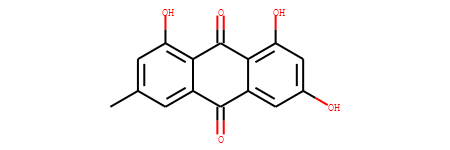

In [3]:
smiles = 'CC1=CC(O)=C2C(=O)C3=C(O)C=C(O)C=C3C(=O)C2=C1'
Chem.MolFromSmiles(smiles)

# 设置阈值并进行搜库

In [4]:
cutoff = '0.8'
web = webService(smiles, cutoff)
df = web.targetBySimilarity()
df.head(1)

200 UTF-8


,monomerid,inhibitor,target,uniprot,species,affinity_type,affinity,doi,smiles,inchi,tanimoto
0,50005912,BDBM50005912,Leukocyte elastase,P08246,Homo sapiens (Human),IC50,13000,10.1021/jm00087a014,Oc1cccc2C(=O)c3ccc(Cc4ccccc4)c(O)c3C(=O)c12,InChI=1S/C21H14O4/c22-16-8-4-7-14-17(16)21(25)...,0.89809


# 对结果自动处理排序

In [5]:
df_sorted = web.sortCol()
df_sorted.head(3)

,monomerid,inhibitor,target,uniprot,species,affinity_type,affinity,doi,smiles,inchi,tanimoto
120,50041802,BDBM50041802,NAD-dependent protein deacetylase sirtuin-5 (S...,Q9NXA8,Homo sapiens (Human),IC50,100,None,Oc1cccc2Cc3cccc(O)c3C(=O)c12,InChI=1S/C14H10O3/c15-10-5-1-3-8-7-9-4-2-6-11(...,0.76974
6,50041419,BDBM50041419,Human immunodeficiency virus type 1 integrase,None,Human immunodeficiency virus 1,IC50,1000,10.1021/jm990322h,Oc1ccc2C(=O)c3c(O)ccc(O)c3C(=O)c2c1O,InChI=1S/C14H8O6/c15-6-3-4-7(16)11-10(6)12(18)...,0.82911
163,50041782,BDBM50041782,Arachidonate 5-lipoxygenase,None,Bos taurus,IC50,1000,10.1021/jm00037a017,Oc1ccc(O)c(Cc2cc(O)c3C(=O)c4c(O)cccc4Cc3c2)c1,InChI=1S/C21H16O5/c22-15-4-5-16(23)13(10-15)6-...,0.83544


# 查看分子结构

D:\Anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 3. Change the maxMols value to display more.
  % (maxMols))


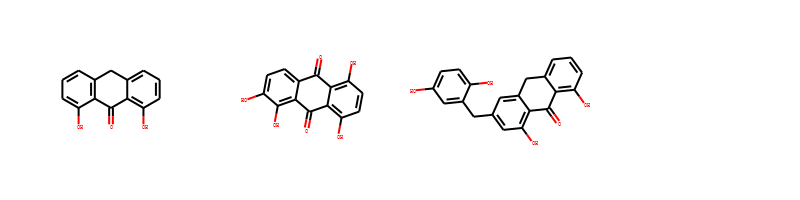

In [6]:
imgs = web.drawMol(n=3)
imgs